In [31]:
import numpy as np

N = 17
np.random.seed(42)

pointsCount = 400
x = np.random.uniform(0, 1000, pointsCount)
y = np.random.uniform(0, 1000, pointsCount)
z = np.random.uniform(0, 100 * N, pointsCount)

points = np.column_stack((x, y, z))

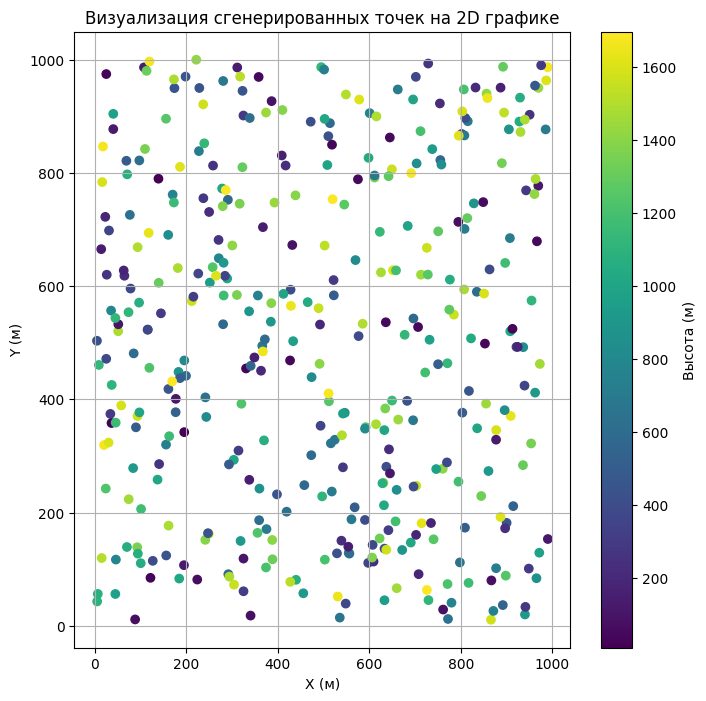

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=z, cmap='viridis', marker='o')
plt.colorbar(label='Высота (м)')
plt.xlabel('X (м)')
plt.ylabel('Y (м)')
plt.title('Визуализация сгенерированных точек на 2D графике')
plt.grid(True)
plt.show()

### Жадная треангуляция

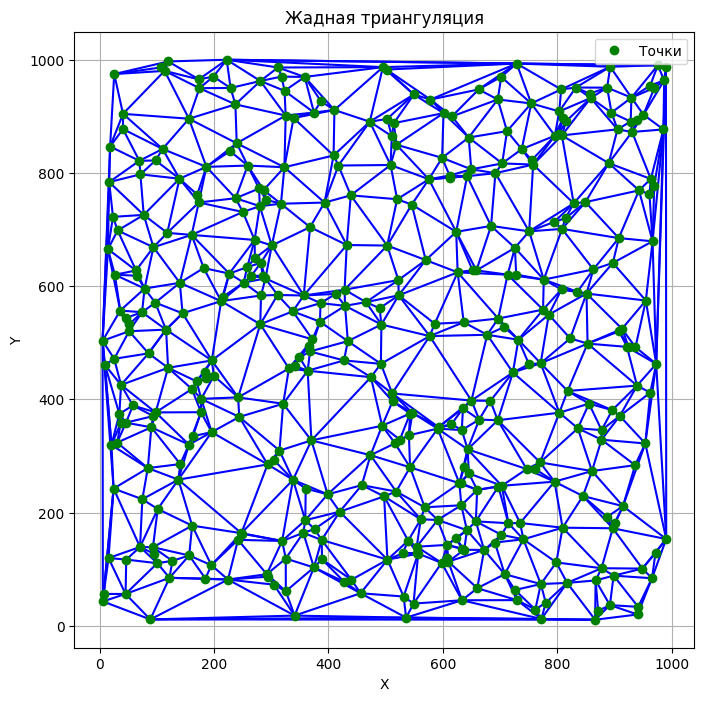

In [33]:
import matplotlib.pyplot as plt


def sign(x):
    return np.sign(x)


def cross_product_2d(a, b):
    return a[0] * b[1] - a[1] * b[0]


def subtract_vectors(v1, v2):
    return [v1[0] - v2[0], v1[1] - v2[1]]


def are_crossing(v11, v12, v21, v22):
    cut1 = subtract_vectors(v12, v11)
    cut2 = subtract_vectors(v22, v21)

    prod1_1 = cross_product_2d(cut1, subtract_vectors(v21, v11))
    prod1_2 = cross_product_2d(cut1, subtract_vectors(v22, v11))

    if sign(prod1_1) == sign(prod1_2) or prod1_1 == 0 or prod1_2 == 0:
        return False

    prod2_1 = cross_product_2d(cut2, subtract_vectors(v11, v21))
    prod2_2 = cross_product_2d(cut2, subtract_vectors(v12, v21))

    if sign(prod2_1) == sign(prod2_2) or prod2_1 == 0 or prod2_2 == 0:
        return False

    return True

def segment_length(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def greedy_triangulation(points):
    n = len(points)
    segments = []

    for i in range(n):
        for j in range(i + 1, n):
            length = segment_length(points[i], points[j])
            segments.append((length, (i, j)))

    segments.sort(key=lambda x: x[0])

    triangulation = []

    for segment in segments:
        i, j = segment[1]
        p1, p2 = points[i], points[j]
        intersects = False

        for existing_segment in triangulation:
            p3, p4 = points[existing_segment[0]], points[existing_segment[1]]
            if are_crossing(p1, p2, p3, p4):
                intersects = True
                break

        if not intersects:
            triangulation.append((i, j))

    return triangulation

triangulation = greedy_triangulation(points)

# Визуализация
plt.figure(figsize=(8, 8))
for segment in triangulation:
    p1, p2 = points[segment[0]], points[segment[1]]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]],color='blue')

plt.plot(points[:, 0], points[:, 1],'o', color='green', label='Точки')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Жадная триангуляция')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
from collections import defaultdict


def is_point_in_triangle(point, triangle_points):
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    d1 = sign(point, triangle_points[0], triangle_points[1])
    d2 = sign(point, triangle_points[1], triangle_points[2])
    d3 = sign(point, triangle_points[2], triangle_points[0])
    

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not (has_neg and has_pos)


def get_triangles_from_edges(edges, points):
    adjacency_list = defaultdict(set)

    for a, b in edges:
        adjacency_list[a].add(b)
        adjacency_list[b].add(a)

    triangles = set()

    for vertex in adjacency_list:
        for neighbor1 in adjacency_list[vertex]:
            for neighbor2 in adjacency_list[vertex]:
                if neighbor1 < neighbor2 and neighbor2 in adjacency_list[neighbor1]:
                    triangle = tuple(sorted([vertex, neighbor1, neighbor2]))
                    triangles.add(triangle)

    triangle_points_list = [
        [points[i] for i in triangle] for triangle in triangles
    ]

    return triangle_points_list


triangles = get_triangles_from_edges(triangulation, points)

In [36]:
def point_triangle(triangles,point):
    for triangle_points in triangles:
        if is_point_in_triangle(point, triangle_points):
            return triangle_points

    return None


def interpolate_height(point, tri):
    vertices = point_triangle(tri,point)
    if vertices is None:
        raise ValueError("Точка не принадлежит триангуляции, интерполяция невозможна.")
    A = vertices[0]
    B = vertices[1]
    C = vertices[2]

    denom = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    if denom == 0:
        raise ValueError("Точки коллинеарны, интерполяция невозможна.")

    
    w1 = ((B[1] - C[1]) * (point[0] - C[0]) + (C[0] - B[0]) * (point[1] - C[1])) / denom
    w2 = ((C[1] - A[1]) * (point[0] - C[0]) + (A[0] - C[0]) * (point[1] - C[1])) / denom
    w3 = 1 - w1 - w2

    height = w1 * A[2] + w2 * B[2] + w3 * C[2]
    return height

Высота в точке (500, 500): 743.07 м


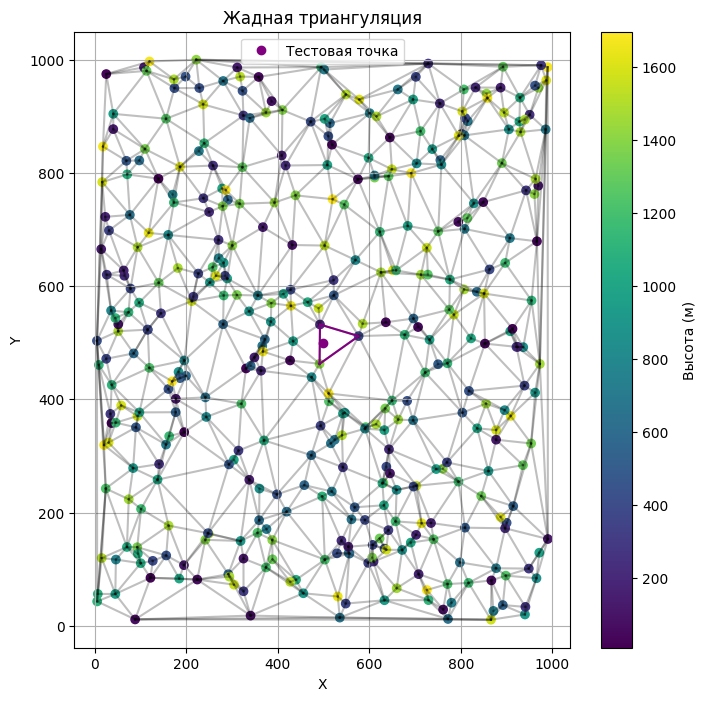

In [45]:
x_test, y_test = 500, 500
target_triangle = point_triangle(triangles,[x_test,y_test])

if not target_triangle is None:
    height = interpolate_height([x_test, y_test], triangles)

    print(f"Высота в точке ({x_test}, {y_test}): {height:.2f} м")

    plt.figure(figsize=(8, 8))
    for segment in triangulation:
        p1, p2 = points[segment[0]], points[segment[1]]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]],color='black', alpha=0.25)
        
    # plt.plot(points[:, 0], points[:, 1],'o', color='green', label='Точки')
    plt.scatter(x, y, c=z, cmap='viridis', marker='o')
    plt.colorbar(label='Высота (м)')
    
    p1,p2,p3 = target_triangle
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]],color='purple')
    plt.plot([p1[0], p3[0]], [p1[1], p3[1]],color='purple')
    plt.plot([p3[0], p2[0]], [p3[1], p2[1]],color='purple')
    plt.plot(x_test, y_test,'o', color='purple', label='Тестовая точка')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Жадная триангуляция')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Точка ({x_test}, {y_test}) не принадлежит жадной триангуляции")

### Итеративный алгоритм «Удаляй и строй»

In [52]:
def circumcircle(A, B, C, tol=1e-12):
    d = 2 * (A[0]*(B[1]-C[1]) + B[0]*(C[1]-A[1]) + C[0]*(A[1]-B[1]))
    if abs(d) < tol:
        return None, None
    A_sq = A[0]**2 + A[1]**2
    B_sq = B[0]**2 + B[1]**2
    C_sq = C[0]**2 + C[1]**2
    center_x = (A_sq*(B[1]-C[1]) + B_sq*(C[1]-A[1]) + C_sq*(A[1]-B[1])) / d
    center_y = (A_sq*(C[0]-B[0]) + B_sq*(A[0]-C[0]) + C_sq*(B[0]-A[0])) / d
    center = np.array([center_x, center_y])
    r_sq = np.sum((A - center)**2)
    return center, r_sq

def delete_and_build_triangulation(points, tol=1e-12):
    n = len(points)
    
    xmin, xmax = np.min(points[:, 0]), np.max(points[:, 0])
    ymin, ymax = np.min(points[:, 1]), np.max(points[:, 1])
    dx = xmax - xmin
    dy = ymax - ymin
    delta = max(dx, dy)
    midx = (xmin + xmax) / 2
    midy = (ymin + ymax) / 2
    A = np.array([midx - 2*delta, midy - delta])
    B = np.array([midx, midy + 2*delta])
    C = np.array([midx + 2*delta, midy - delta])
    supertriangle = np.array([A, B, C])
    
    points_ext = np.vstack([points, supertriangle])
    triangulation = [(n, n+1, n+2)]
    
    for i, p in enumerate(points):
        bad_triangles = []
        for tri in triangulation:
            A_idx, B_idx, C_idx = tri
            A_pt = points_ext[A_idx]
            B_pt = points_ext[B_idx]
            C_pt = points_ext[C_idx]
            center, r_sq = circumcircle(A_pt, B_pt, C_pt, tol)
            if center is None:
                continue
            if np.sum((p - center)**2) < r_sq - tol:
                bad_triangles.append(tri)
                
        edge_count = {}
        for tri in bad_triangles:
            edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
            for edge in edges:
                edge_sorted = tuple(sorted(edge))
                edge_count[edge_sorted] = edge_count.get(edge_sorted, 0) + 1
        
        boundary_edges = [edge for edge, count in edge_count.items() if count == 1]
        
        triangulation = [tri for tri in triangulation if tri not in bad_triangles]
        
        for edge in boundary_edges:
            new_tri = (edge[0], edge[1], i)
            triangulation.append(new_tri)
    
    final_triangles = [tri for tri in triangulation if all(v < n for v in tri)]
    
    return final_triangles

triangles_dealoune = delete_and_build_triangulation(points[:, :2])

def convert_to_point_trinagles(triangles):
    ans = []
    for tri in triangles:
        p1,p2,p3 = tri
        ans.append([points[p1],points[p2],points[p3]])

    return ans

triangles_dealoune_points = convert_to_point_trinagles(triangles_dealoune)

Высота в точке (500, 500): 743.07 м


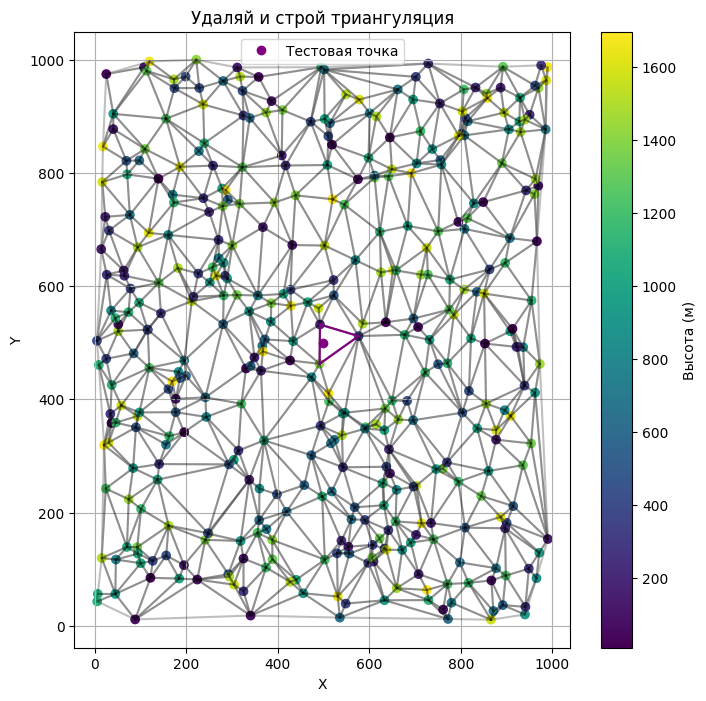

In [53]:
x_test, y_test = 500, 500
target_triangle = point_triangle(triangles_dealoune_points,[x_test,y_test])

if not target_triangle is None:
    height = interpolate_height([x_test, y_test], triangles_dealoune_points)

    print(f"Высота в точке ({x_test}, {y_test}): {height:.2f} м")

    plt.figure(figsize=(8, 8))
    for tri in triangles_dealoune:
        pts = points[list(tri)]
        pts = np.vstack([pts, pts[0]])  # замыкаем контур треугольника
        plt.plot(pts[:, 0], pts[:, 1], color="black", alpha=0.25)
        
    # plt.plot(points[:, 0], points[:, 1],'o', color='green', label='Точки')
    plt.scatter(x, y, c=z, cmap='viridis', marker='o')
    plt.colorbar(label='Высота (м)')
    
    p1,p2,p3 = target_triangle
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]],color='purple')
    plt.plot([p1[0], p3[0]], [p1[1], p3[1]],color='purple')
    plt.plot([p3[0], p2[0]], [p3[1], p2[1]],color='purple')
    plt.plot(x_test, y_test,'o', color='purple', label='Тестовая точка')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Удаляй и строй триангуляция')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Точка ({x_test}, {y_test}) не принадлежит жадной триангуляции")